инструкция:
     https://www.kaggle.com/general/74235

# загрузка данных

In [ ]:
! pip install -q kaggle # установил библиотеку для Кэггл
from google.colab import files #импорт служебной штуки для загрузки файлов в колаб
files.upload() # собственно аплоад самого файла токена, создается на кэглл в аккаунте и скачивается
! mkdir ~/.kaggle # по хорошему надо было создать директорию, но ругается т.к. такая уже есть
! cp kaggle.json ~/.kaggle/ # копирование файла токена в нужную директорию
! chmod 600 ~/.kaggle/kaggle.json # смена прав доступа, 600 только владелец файла может читать/записывать, взято из инструкции с Кэглла
! kaggle competitions download -c new-york-city-taxi-fare-prediction

Saving kaggle.json to kaggle.json
 99% 1.55G/1.56G [00:25<00:00, 68.7MB/s]
100% 1.56G/1.56G [00:25<00:00, 64.7MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 129MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 108MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 501kB/s]


In [ ]:
! unzip '/content/train.csv.zip'

Archive:  /content/train.csv.zip
  inflating: train.csv               


#установка и импорт библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q 'fsspec>=0.3.3'

     |████████████████████████████████| 132 kB 4.9 MB/s 


In [3]:
! pip install -q pyspark

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 65.7 MB/s 


In [1]:
import pyspark
import pyspark.sql.functions as F
#JVM типы данных
from pyspark.sql.types import DoubleType, \
IntegerType, \
StructType, \
 StructField, \
  StringType, \
   TimestampType, \
    LongType, \
    FloatType, \
    ShortType, \
    ByteType
#JVM типы данных
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

import numpy as np
import pandas as pd
import dask.dataframe as dd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from shapely import geometry
import pickle

#spark сессия с имененм прилажухи, потом объясню для чего оно

In [4]:
spark = SparkSession.builder.master(
    "local[*]"
    ).appName(
    "DS5_8"
    ).config(
        "spark.sql.execution.arrow.pyspark.enabled", 
        "true").getOrCreate()

In [5]:
spark # spark is alive

In [ ]:
df = dd.read_csv('train.csv') # быстренько читаем в даск

In [ ]:
# new_train = dd.read_parquet('/content/drive/MyDrive/@/train_1.parquet')


# train_500 = new_train.sample(frac=0.01)
# df_500K = train_500.compute()
# df_500K.to_csv('new_train_500.csv', index=False)
# train_500.to_parquet('/content/drive/MyDrive/@/train_500.parquet')

In [ ]:
# schema = StructType([StructField("key",StringType(),True), 
#                      StructField("fare_amount",DoubleType(),True), 
#                      StructField("pickup_datetime",StringType(),True), 
#                      StructField("pickup_longitude", DoubleType(), True), 
#                      StructField("pickup_latitude", DoubleType(), True), 
#                      StructField("dropoff_longitude", DoubleType(), True), 
#                      StructField("dropoff_latitude", DoubleType(), True), 
#                      StructField("passenger_count", LongType(), True)
#                      ])

In [ ]:
df.to_parquet('/content/drive/MyDrive/@/train.parquet') # быстренько пишемся в паркет, работает паркет быстрее чем на прямую из csv

In [ ]:
# schema_small = StructType([StructField("key",StringType(),True), 
#                      StructField("fare_amount",FloatType(),True), 
#                      StructField("pickup_datetime",StringType(),True), 
#                      StructField("pickup_longitude", FloatType(), True), 
#                      StructField("pickup_latitude", FloatType(), True), 
#                      StructField("dropoff_longitude", FloatType(), True), 
#                      StructField("dropoff_latitude", FloatType(), True), 
#                      StructField("passenger_count", ByteType(), True)
#                      ])

In [ ]:
# data = spark.read.format("csv").option("header", True).schema(schema_small).load("train.csv")

In [ ]:
# ! rm -rf /content/drive/MyDrive/@/new_data.parquet

# читаем

In [ ]:
data = spark.read.parquet('/content/drive/MyDrive/@/train.parquet') #датасет в датафрейм

In [ ]:
data = data.drop('index') # нафиг индекс

In [ ]:
data.printSchema() # схема типов данных

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: long (nullable = true)



In [ ]:
data.show() # смотрим кусочек

+--------------------+-----------+--------------------+------------------+------------------+------------------+------------------+---------------+
|                 key|fare_amount|     pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|
+--------------------+-----------+--------------------+------------------+------------------+------------------+------------------+---------------+
|2010-02-26 21:16:...|        8.1|2010-02-26 21:16:...|         -73.98055|           40.7748|        -73.955208|40.767602000000004|              2|
|2012-04-23 07:43:...|        4.1|2012-04-23 07:43:...|        -73.964878|          40.75564|        -73.974467|         40.751963|              1|
|2015-03-09 22:52:...|       10.5|2015-03-09 22:52:...|-73.97380828857422|40.784278869628906|-73.94236755371094| 40.78980255126953|              1|
|2011-02-23 08:20:...|        5.7|2011-02-23 08:20:...|        -73.973903|         40.763247|        -73.983395|

#EDA

In [ ]:
# целевая переменная в зависимости от количества пассажиров
data.groupBy('passenger_count') \
  .agg(F.avg('fare_amount').alias('fare_amount_avg'), 
       F.min('fare_amount').alias('fare_amount_min'),
       F.max('fare_amount').alias('fare_amount_max'),
       F.count('fare_amount').alias('count')) \
  .sort(F.col('fare_amount_avg').desc()) \
  .show()

+---------------+------------------+---------------+---------------+--------+
|passenger_count|   fare_amount_avg|fare_amount_min|fare_amount_max|   count|
+---------------+------------------+---------------+---------------+--------+
|              9| 36.99304347826087|            2.5|          104.0|      23|
|              7|31.788666666666664|            2.5|           88.0|      15|
|              8|29.981111111111108|            2.5|           85.0|       9|
|             34|              13.3|           13.3|           13.3|       1|
|              6|12.126156360165988|          -60.0|          477.0| 1174647|
|              2|11.838421254268157|         -176.0|       93963.36| 8175243|
|              4|11.766069107911711|         -57.33|          978.0| 1178852|
|              3|11.540596515329295|         -300.0|          500.0| 2432712|
|              1|11.216405297848935|         -300.0|       75747.02|38337524|
|              5|11.208400548080803|          -67.5|         102

In [ ]:
print((data.count(), len(data.columns))) # shape

(55423856, 8)


In [ ]:
data.createOrReplaceTempView('datatable') # временное представление ввиде SQL-таблицы

In [ ]:
# используя SQL-запрос обрежем все где целевая колонка меньше 0 и больше 150
r = """
select * from datatable
where fare_amount>=0 and fare_amount<150
"""
data = spark.sql(r)
print((data.count(), len(data.columns)))

(55415718, 8)


In [ ]:
data.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in data.columns]).show() # чекаем NA

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|                0|               0|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



In [ ]:
data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in data.columns]).show() # т.к. замешана JVM чекаем и NULL

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|  0|          0|              0|               0|              0|              376|             376|              0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



# очистка

In [ ]:
data = data.na.drop() # дропаем NA и NULL

In [ ]:
# ограничимся в пассажирах
data = data.filter(data['passenger_count'] > 0)
data = data.filter(data['passenger_count'] <= 6)

In [ ]:
# ограничим область координат
data = data.filter(data['pickup_latitude'].between(40.3, 41.12))
data = data.filter(data['dropoff_latitude'].between(40.3, 41.12))
data = data.filter(data['pickup_longitude'].between(-74.46, -73.5))
data = data.filter(data['dropoff_longitude'].between(-74.46, -73.5))

In [ ]:
data.groupBy('passenger_count') \
  .agg(F.avg('fare_amount').alias('fare_amount_avg'), 
       F.min('fare_amount').alias('fare_amount_min'),
       F.max('fare_amount').alias('fare_amount_max'),
       F.count('fare_amount').alias('count')) \
  .sort(F.col('fare_amount_avg').desc()) \
  .show()

+---------------+------------------+---------------+------------------+--------+
|passenger_count|   fare_amount_avg|fare_amount_min|   fare_amount_max|   count|
+---------------+------------------+---------------+------------------+--------+
|              6|12.120595458782189|            0.0|147.32999999999996| 1150088|
|              2|11.787512477821506|            0.0|            149.85| 8008009|
|              4|11.724152082279787|            0.0|             149.0| 1154888|
|              3|11.505926017375428|            0.0|            149.75| 2381397|
|              5|11.207392688422663|            0.0|            148.33| 3840895|
|              1|11.169233168081874|            0.0|            149.99|37493914|
+---------------+------------------+---------------+------------------+--------+



In [ ]:
print((data.count(), len(data.columns)))

(54029191, 8)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


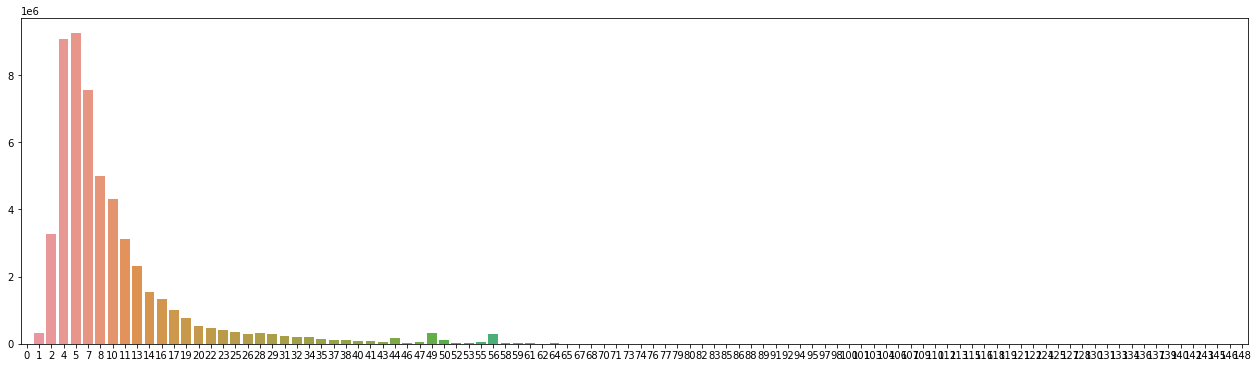

In [ ]:
# гистограмма цели
h = data.select('fare_amount').rdd.flatMap(lambda x: x).histogram(100);
plt.figure(figsize=(22,6));
sns.barplot(list(map(lambda x: int(x), h[0][:-1])), h[1]);

#Feature engineering

In [ ]:
# дистанция с учетом круглости земли
from geopy.distance import great_circle

@F.udf(LongType())
def get_circle(lat_pick, lon_pick, lat_drop, lon_drop):
    return round(great_circle((lat_pick, lon_pick), (lat_drop, lon_drop)).m)

In [ ]:
data = data.withColumn("distance", get_circle(data['pickup_latitude'], 
                                            data['pickup_longitude'], 
                                            data['dropoff_latitude'], 
                                            data['dropoff_longitude']))

In [ ]:
# направление в градусах
from geographiclib.geodesic import Geodesic

@F.udf(DoubleType())
def get_bearing(lat1, lat2, long1, long2):
    return Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']

In [ ]:
data = data.withColumn("bearing", get_bearing(data['pickup_latitude'], 
                                              data['dropoff_latitude'], 
                                              data['pickup_longitude'], 
                                              data['dropoff_longitude']))

In [12]:
from math import cos

@F.udf(DoubleType())
def get_cos(bearing):
    return cos(bearing)

In [ ]:
data = data.withColumn("cos_bearing", get_cos(data['bearing']))

In [ ]:
#datetime признаки

data = data.withColumn('dayofweek', F.dayofweek(data['pickup_datetime']))
data = data.withColumn('hour', F.hour(data['pickup_datetime']))

data = data.withColumn('peak_surcharge',
                       F.when((data['hour']>=16) &
                              (data['hour']<20) &
                              (data['dayofweek']!=7) & 
                              (data['dayofweek']!=1), 1).otherwise(0))

data = data.withColumn('night_surcharge', 
                       F.when((data['hour']>=20) | (data['hour']<6), 1).otherwise(0))

data = data.withColumn('year', F.year(data['pickup_datetime']))
data = data.withColumn('month', F.month(data['pickup_datetime']))
data = data.withColumn('date', F.dayofmonth(data['pickup_datetime']))

In [ ]:
# бинарный признак удорожания в 2012 году
data = data.withColumn('after_oct_2012', 
                       F.when(
                           (
                           (data['year'] == 2012) &
                            (data['month'] >= 9)
                            ) | (data['year'] > 2012), 1).otherwise(0))

In [ ]:
data.show() # смотрим результат

+--------------------+-----------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+
|                 key|fare_amount|     pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|distance|            bearing|         cos_bearing|dayofweek|hour|peak_surcharge|night_surcharge|year|month|date|after_oct_2012|
+--------------------+-----------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+
|2010-02-26 21:16:...|        8.1|2010-02-26 21:16:...|         -73.98055|           40.7748|        -73.955208|40.767602000000004|              2|    2279| 110.47772661800482

In [ ]:
data.printSchema() # смотрим типы данных, можно подумать чтоб перекастовать в менее ресурсоемкие типы

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- distance: long (nullable = true)
 |-- bearing: double (nullable = true)
 |-- cos_bearing: double (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- peak_surcharge: integer (nullable = false)
 |-- night_surcharge: integer (nullable = false)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- after_oct_2012: integer (nullable = false)



In [ ]:
print((data.count(), len(data.columns)))

(54029191, 19)


In [ ]:
data.show()

+--------------------+-----------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+---+
|                 key|fare_amount|     pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|distance|            bearing|         cos_bearing|dayofweek|hour|peak_surcharge|night_surcharge|year|month|date|after_oct_2012|JFK|
+--------------------+-----------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+---+
|2010-02-26 21:16:...|        8.1|2010-02-26 21:16:...|         -73.98055|           40.7748|        -73.955208|40.767602000000004|              2|    2279| 110.47

In [ ]:
# сохраним результаты в новый паркет, занимает около 6-7 часов в 2 потока и 3-4 часа в 5 потоков

data.write.parquet('/content/drive/MyDrive/@/trainW0.parquet')

#пробуем модели 

In [23]:
df_train = spark.read.parquet('/content/drive/MyDrive/@/train_1.parquet')

In [13]:
# df_train = df_train.withColumn("cos_pickup_longitude", get_cos(df_train['pickup_longitude']))

In [14]:
# df_train = df_train.withColumn("cos_pickup_latitude", get_cos(df_train['pickup_latitude']))
# df_train = df_train.withColumn("cos_dropoff_longitude", get_cos(df_train['dropoff_longitude']))
# df_train = df_train.withColumn("cos_dropoff_latitude", get_cos(df_train['dropoff_latitude']))

In [15]:
df_train.show()

+--------------------+-----------+--------------------+-----------------+-----------------+------------------+-----------------+---------------+--------+-------------------+---------+----+--------------+---------------+----+-----+----+--------------+--------------------+--------------------+-------------------+---------------------+--------------------+
|                 key|fare_amount|     pickup_datetime| pickup_longitude|  pickup_latitude| dropoff_longitude| dropoff_latitude|passenger_count|distance|            bearing|dayofweek|hour|peak_surcharge|night_surcharge|year|month|date|after_oct_2012|         cos_bearing|cos_pickup_longitude|cos_pickup_latitude|cos_dropoff_longitude|cos_dropoff_latitude|
+--------------------+-----------+--------------------+-----------------+-----------------+------------------+-----------------+---------------+--------+-------------------+---------+----+--------------+---------------+----+-----+----+--------------+--------------------+-----------------

In [24]:
(trainingData, testData) = df_train.randomSplit([0.7, 0.3], seed=8)

In [25]:
chosen_few = ['pickup_longitude',
              'pickup_latitude',
              'dropoff_longitude',
              'dropoff_latitude',
              'passenger_count',
              'distance',
              'bearing',
              'dayofweek',
              'hour',
              'peak_surcharge',
              'night_surcharge',
              'year',
              'month',
              'date',
              'after_oct_2012']

another_chosen_few = ['cos_pickup_longitude',
              'cos_pickup_latitude',
              'cos_dropoff_longitude',
              'cos_dropoff_latitude',
              'passenger_count',
              'distance',
              'cos_bearing',
              'dayofweek',
              'hour',
              'peak_surcharge',
              'night_surcharge',
              'year',
              'month',
              'date',
              'after_oct_2012']

In [26]:
vectorAssembler = VectorAssembler(
    inputCols=chosen_few,
    outputCol='rawFeatures')

In [27]:
vectorIndexer = VectorIndexer(
    inputCol="rawFeatures", outputCol="features", maxCategories=4)

In [28]:
trainingData = vectorAssembler.setHandleInvalid("skip").transform(trainingData)
testData = vectorAssembler.setHandleInvalid("skip").transform(testData)

In [29]:
trainingData = vectorIndexer.setHandleInvalid("skip").fit(trainingData).transform(trainingData)
testData = vectorIndexer.setHandleInvalid("skip").fit(testData).transform(testData)

In [ ]:
# trainingData.limit(3).toPandas()['features'][0]

In [ ]:
# gbt = GBTRegressor(featuresCol='features', labelCol='fare_amount')
# model_gbt_more = gbt.fit(trainingData)
# predictions = model_gbt_more.transform(testData)

# evaluator = RegressionEvaluator(
#     labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

# rmse = evaluator.evaluate(predictions)
# print("GBT model. RMSE на валидационке = %g" % rmse)

GBT model. RMSE на валидационке = 3.95671


In [ ]:
gbt = GBTRegressor(featuresCol='features', labelCol='fare_amount')
model_gbt_more = gbt.fit(trainingData)
predictions = model_gbt_more.transform(testData)


evaluator = RegressionEvaluator(
    labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("GBT model. RMSE на валидационке = %g" % rmse)

GBT model. RMSE на валидационке = 3.97589


///

In [ ]:
# model_gbt_more.save("/content/drive/MyDrive/@/models/model_gbt_idx")

In [31]:
from pyspark.ml.regression import LinearRegression

In [30]:
from pyspark.ml.feature import StandardScaler

sc = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='sc_l_features')

In [32]:
scl = sc.fit(trainingData)

In [33]:
sc_trainingData = scl.transform(trainingData)
sc_testData = scl.transform(testData)

In [35]:
lr = LinearRegression(maxIter=100, 
                      regParam=0.1, 
                      elasticNetParam=0.6, 
                      featuresCol='sc_l_features', 
                      labelCol='fare_amount')

lrModel = lr.fit(sc_trainingData)

lr_predictions = lrModel.transform(sc_testData)

In [36]:
evaluator_lr = RegressionEvaluator(
    labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

rmse_lr = evaluator_lr.evaluate(lr_predictions)
print("linear model. RMSE на валидационке = %g" % rmse_lr)

linear model. RMSE на валидационке = 4.50188


In [ ]:
model_gbt_more.save("/content/drive/MyDrive/@/models/model_lr_idx")

In [6]:
sub = dd.read_csv('/content/drive/MyDrive/@/test_with_all.csv')

In [7]:
sub.to_parquet('/content/drive/MyDrive/@/sub.parquet')

In [8]:
sub_spark = spark.read.parquet('/content/drive/MyDrive/@/sub.parquet')

In [9]:
sub_spark.show()

+--------------------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+-----+
|                 key|     pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|distance|            bearing|         cos_bearing|dayofweek|hour|peak_surcharge|night_surcharge|year|month|date|after_oct_2012|index|
+--------------------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+-----+
|2015-01-27 13:08:...|2015-01-27 13:08:...|-73.97332000732422|  40.7638053894043|-73.98143005371094| 40.74383544921875|              1|    2323|-162.83515587516212|    0.86398659208832|        

In [37]:
subData = vectorAssembler.setHandleInvalid("skip").transform(sub_spark)
subData = vectorIndexer.setHandleInvalid("skip").fit(subData).transform(subData)


In [38]:
sc_subData = scl.transform(subData)

In [77]:
sc_subData.show()

+--------------------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+-----+--------------------+--------------------+--------------------+
|                 key|     pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|distance|            bearing|         cos_bearing|dayofweek|hour|peak_surcharge|night_surcharge|year|month|date|after_oct_2012|index|         rawFeatures|            features|       sc_l_features|
+--------------------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+-----+--------------------+--------------------+--------------------+
|201

https://ranjithmenon.medium.com/gradient-boosted-tree-regression-spark-dd5ac316a252

In [18]:
from pyspark.ml.regression import GBTRegressionModel

In [19]:
model_gbt = GBTRegressionModel.load("/content/drive/MyDrive/@/models/model_gbt_more")

In [56]:
predictions_gbt = model_gbt.transform(subData)

In [57]:
predictions_gbt.show()

+--------------------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+-----+--------------------+--------------------+------------------+
|                 key|     pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|distance|            bearing|         cos_bearing|dayofweek|hour|peak_surcharge|night_surcharge|year|month|date|after_oct_2012|index|         rawFeatures|            features|        prediction|
+--------------------+--------------------+------------------+------------------+------------------+------------------+---------------+--------+-------------------+--------------------+---------+----+--------------+---------------+----+-----+----+--------------+-----+--------------------+--------------------+------------------+
|2015-01-2

In [59]:
ds5_k8_spark_gbt = predictions_gbt.select('key', 
                                          'prediction').withColumnRenamed('prediction', 
                                                                          'fare_amount')

In [61]:
ds5_k8_spark_gbt.toPandas().to_csv('ds5_k8_spark_gbt_sub', index=False)

In [39]:
# from pyspark.ml.regression import LinearRegressionModel

# lrModel_new = LinearRegressionModel.load('/content/drive/MyDrive/@/models/model_lr_idx')

lr_predictions_sub = lrModel.transform(sc_subData)

In [40]:
ds5_k8_spark_lr = lr_predictions_sub.select('key', 
                                          'prediction').withColumnRenamed('prediction', 
                                                                          'fare_amount')

In [41]:
ds5_k8_spark_lr.show()

+--------------------+------------------+
|                 key|       fare_amount|
+--------------------+------------------+
|2015-01-27 13:08:...|10.162962746041504|
|2015-01-27 13:08:...|10.722918879172997|
|2011-10-08 11:53:...| 5.653036535413829|
|2012-12-01 21:12:...| 8.389241730462253|
|2012-12-01 21:12:...|16.382486352334144|
|2012-12-01 21:12:...|11.710793589517545|
|2011-10-06 12:10:...| 5.438776259176566|
|2011-10-06 12:10:...| 54.26724148444329|
|2011-10-06 12:10:...|11.631605250957335|
|2014-02-18 15:22:...| 7.518475715451752|
|2014-02-18 15:22:...|10.167730159583634|
|2014-02-18 15:22:...|15.418792305904265|
|2010-03-29 20:20:...|3.6445513453359712|
|2010-03-29 20:20:...| 5.762471583576527|
|2011-10-06 03:59:...|  7.97497853924968|
|2011-10-06 03:59:...|13.298785532300277|
|2012-07-15 16:45:...|3.7397219924871408|
|2012-07-15 16:45:...| 9.378188303718783|
|2012-07-15 16:45:...| 6.041414557790479|
|2012-07-15 16:45:...| 4.191687956765462|
+--------------------+------------

In [42]:
ds5_k8_spark_lr.toPandas().to_csv('ds5_k8_spark_lr_sub', index=False)

https://stackoverflow.com/questions/48826386/hyperparameter-tuning-using-pyspark

# увы, не получилось. граф надо переделывать чтоб id точек были int. иначе непростительно долго

In [ ]:
! pip install -q taxicab

import taxicab as tc

from osmnx import graph_from_bbox
xmin, xmax = -74.46, -73.5
ymin, ymax =  40.3, 41.12
G = graph_from_bbox(ymax, ymin, xmin, xmax, network_type='drive', simplify=True)

from osmnx import save_graphml
save_graphml(G, 'ds5_k8_graph.graphml')

from osmnx import load_graphml
G1 = load_graphml('ds5_k8_graph.graphml')

In [ ]:
@F.udf(DoubleType())
def get_track(lat1, lat2, long1, long2):
    orig = (lat1, long1)
    dest = (lat2, long2)
    return tc.distance.shortest_path(G1, orig, dest)

In [ ]:
train = train.withColumn("track", get_track(train['pickup_latitude'], 
                                            train['dropoff_latitude'], 
                                            train['pickup_longitude'], 
                                            train['dropoff_longitude']))